In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
import librosa
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils import data
from collections import OrderedDict
from torch.nn.parameter import Parameter
from torch.autograd import Variable

C:\Users\ankur\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [78]:
class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size,in_channels=1,sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):

        super(SincConv,self).__init__()

        if in_channels != 1:
            
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)
        
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device = device   
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        
        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')
        
        
        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)
        fmel=self.to_mel(f)   # Hz to mel conversion
        fmelmax=np.max(fmel)
        fmelmin=np.min(fmel)
        filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+1)
        filbandwidthsf=self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel=filbandwidthsf
        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels,self.kernel_size)
    
       
        
    def forward(self,x):
        for i in range(len(self.mel)-1):
            fmin=self.mel[i]
            fmax=self.mel[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow
            
            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)
        
        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)
        
        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)
        
class Residual_block(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block, self).__init__()
        self.first = first
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.3)
        
        self.conv1 = nn.Conv1d(in_channels = nb_filts[0],
			out_channels = nb_filts[1],
			kernel_size = 3,
			padding = 1,
			stride = 1)
        
        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1],
			out_channels = nb_filts[1],
			padding = 1,
			kernel_size = 3,
			stride = 1)
        
        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0],
				out_channels = nb_filts[1],
				padding = 0,
				kernel_size = 1,
				stride = 1)
            
        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)
        
    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(x)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)
        
        if self.downsample:
            identity = self.conv_downsample(identity)
            
        out += identity
        out = self.mp(out)
        return out

class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()

        
        self.device=device

        self.Sinc_conv=SincConv(device=self.device,
			out_channels = d_args['filts'][0],
			kernel_size = d_args['first_conv'],
                        in_channels = d_args['in_channels']
        )
        
        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.selu = nn.SELU(inplace=True)
        self.block0 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1], first = True))
        self.block1 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1]))
        self.block2 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block4 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block5 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc_attention0 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features = d_args['filts'][1][-1],
            l_out_features = d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features = d_args['filts'][2][-1],
            l_out_features = d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1],
			hidden_size = d_args['gru_node'],
			num_layers = d_args['nb_gru_layer'],
			batch_first = True)

        
        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'],
			out_features = d_args['nb_fc_node'])
       
        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'],
			out_features = d_args['nb_classes'],bias=True)
			
       
        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, y = None):
        
        
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x=x.view(nb_samp,1,len_seq)
        
        x = self.Sinc_conv(x)    
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x =  self.selu(x)
        
        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1) # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)
        
        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1) # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1 # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1) # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2 # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1) # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3 # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1) # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4 # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1) # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5 # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.permute(0, 2, 1)     #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        x = self.fc1_gru(x)
        x = self.fc2_gru(x)
        output=self.logsoftmax(x)
      
        return output
        
        
    def _make_attention_fc(self, in_features, l_out_features):

        l_fc = []
        
        l_fc.append(nn.Linear(in_features = in_features,
			        out_features = l_out_features))

        

        return nn.Sequential(*l_fc)


    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
				first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)

In [79]:
d_args = {'nb_samp': 64600, 'first_conv': 1024,  'in_channels': 1, 'filts': [20, [20, 20], [20, 128], [128, 128]], 
         'blocks': [2, 4], 'nb_fc_node': 1024, 'gru_node': 1024, 'nb_gru_layer': 3, 'nb_classes': 2}

In [80]:
d_args['filts'][2][1]

128

In [84]:
model = RawNet(d_args, 'cpu')

# b = torch.randn(100,10000)
# c = model(b)
# print(c.shape)

In [82]:
# summary(64600, batch_size=-1, device="cpu", print_fn = None)
model.summary((50000,), print_fn = print)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          SincConv-1            [-1, 20, 48976]               0
       BatchNorm1d-2            [-1, 20, 16325]              40
              SELU-3            [-1, 20, 16325]               0
            Conv1d-4            [-1, 20, 16325]           1,220
       BatchNorm1d-5            [-1, 20, 16325]              40
         LeakyReLU-6            [-1, 20, 16325]               0
            Conv1d-7            [-1, 20, 16325]           1,220
         MaxPool1d-8             [-1, 20, 5441]               0
    Residual_block-9             [-1, 20, 5441]               0
AdaptiveAvgPool1d-10                [-1, 20, 1]               0
           Linear-11                   [-1, 20]             420
          Sigmoid-12                   [-1, 20]               0
      BatchNorm1d-13             [-1, 20, 5441]              40
        LeakyReLU-14             [-1, 2

In [19]:
class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):

        super(SincConv,self).__init__()

        if in_channels != 1:
            
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)
        
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device = device   
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        
        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')
        
        
        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)
        fmel=self.to_mel(f)   # Hz to mel conversion
        fmelmax=np.max(fmel)
        fmelmin=np.min(fmel)
        filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+1)
        filbandwidthsf=self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel=filbandwidthsf
        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels,self.kernel_size)
    
       
        
    def forward(self,x):
        for i in range(len(self.mel)-1):
            fmin=self.mel[i]
            fmax=self.mel[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow
            
            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)
        
        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)
        
        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)

In [ ]:
SincConv(device=self.device, out_channels = d_args['filts'][0], kernel_size = d_args['first_conv'],
         in_channels = d_args['in_channels'])

In [20]:
d_args = {'nb_samp': 64600, 'first_conv': 1024,  'in_channels': 1, 'filts': [20, [20, 20], [20, 128], [128, 128]], 
         'blocks': [2, 4], 'nb_fc_node': 1024, 'gru_node': 1024, 'nb_gru_layer': 3, 'nb_classes': 2}

In [21]:
d_args['filts'][0]

20

In [23]:
kernel_size = 1024

if kernel_size%2==0:
    kernel_size=kernel_size+1
    
print(kernel_size)

1025


In [27]:
NFFT = 512
sample_rate = 16000
f=int(sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)

print(f.shape)

(257,)


In [29]:
def to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

In [34]:
out_channels = 20

In [43]:
fmel=to_mel(f)   # Hz to mel conversion
fmelmax=np.max(fmel)
fmelmin=np.min(fmel)
filbandwidthsmel=np.linspace(fmelmin,fmelmax,out_channels+1)
filbandwidthsf=to_hz(filbandwidthsmel)  # Mel to Hz conversion
mel=filbandwidthsf
hsupp=torch.arange(-(kernel_size-1)/2, (kernel_size-1)/2+1)
band_pass=torch.zeros(out_channels,kernel_size)

In [48]:
mel.shape

(21,)

In [71]:
for i in range(len(mel)-1):
    fmin=mel[i]
    fmax=mel[i+1]
    hHigh=(2*fmax/sample_rate)*np.sinc(2*fmax*hsupp/sample_rate)
    # print(hHigh)
    hLow=(2*fmin/sample_rate)*np.sinc(2*fmin*hsupp/sample_rate)
    hideal=hHigh-hLow

    band_pass[i,:]=Tensor(np.hamming(kernel_size))*Tensor(hideal)

In [72]:
band_pass.shape

torch.Size([20, 1025])

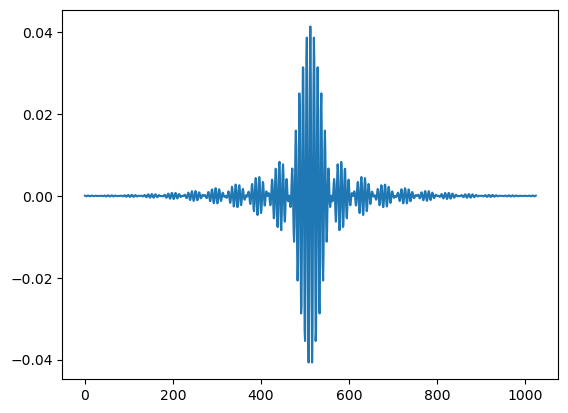

In [53]:
import matplotlib.pyplot as plt
a = band_pass[10,:]
plt.plot(a)

In [65]:
fmin=mel[2]
fmax=mel[3]
hHigh=(2*fmax/sample_rate)*np.sinc(2*fmax*hsupp/sample_rate)
hLow=(2*fmin/sample_rate)*np.sinc(2*fmin*hsupp/sample_rate)

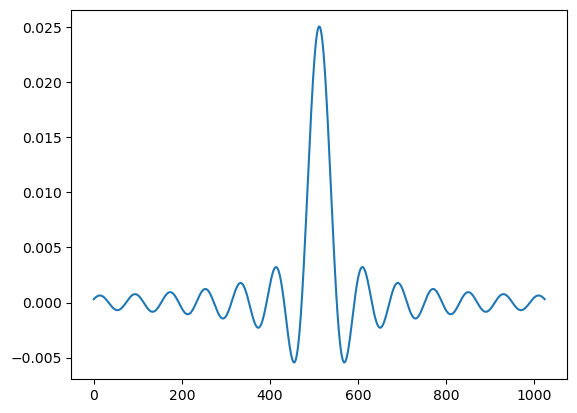

In [68]:
a = hHigh
b = hLow
plt.plot(b)

In [70]:
inputs = torch.randn(33, 16, 30)
filters = torch.randn(20, 16, 5)
F.conv1d(inputs, filters).shape

torch.Size([33, 20, 26])

torch.Size([20, 1, 1025])